# Projeto Câncer de Pulmão

O câncer de pulmão é responsável por um número significativo de mortes anuais. Esta doença caracteriza-se pelo crescimento descontrolado de células no pulmão, que pode se espalhar para outras partes do corpo. Fatores de risco como tabagismo, exposição a poluentes ambientais e substâncias tóxicas, além de predisposição genética, estão fortemente associados ao desenvolvimento da doença. O diagnóstico precoce e o tratamento adequado são fundamentais para aumentar as chances de sobrevivência, mas muitas vezes a doença é descoberta em estágios avançados, o que dificulta o sucesso terapêutico.

Este conjunto de dados consiste em 5.000 registros com 18 características relacionadas a fatores de risco e previsão de câncer de pulmão. Inclui informações demográficas, hábitos de vida, histórico médico e sintomas associados à doença pulmonar. O objetivo do projeto é realizar tratamento dos dados, análise exploratória e criação de modelo de machine learning com foco em previsão de risco de desenvolvimento de câncer de pulmão.

Fonte dos dados: [Kaggle](https://www.kaggle.com/datasets/shantanugarg274/lung-cancer-prediction-dataset)

## Dicionário de dados


`AGE` (idade): idade dos pacientes;

`GENDER`: sexo dos pacientes -> não há informação sobre qual é o 0 e qual é o 1

`SMOKING`: fumante -> 0 = Não, 1 = Sim;

`FINGER_DISCOLORATION`: descoloração dos dedos -> 0 = Não, 1 = Sim;

`MENTAL_STRESS`: estresse mental -> 0 = Não, 1 = Sim;

`EXPOSURE_TO_POLLUTION`: exposição à poluição -> 0 = Não, 1 = Sim;

`LONG_TERM_ILLNESS`: doença prolongada -> 0 = Não, 1 = Sim;

`ENERGY_LEVEL`: nível de energia dos pacientes;

`IMMUNE_WEAKNESS`: imunidade comprometida -> 0 = Não, 1 = Sim;

`BREATHING_ISSUE`: problemas respiratórios -> 0 = Não, 1 = Sim;

`ALCOHOL_CONSUMPTION`: consumo de álcool -> 0 = Não, 1 = Sim;

`THROAT_DISCOMFORT`: desconforto na garganta -> 0 = Não, 1 = Sim;

`OXYGEN_SATURATION`: saturação de oxigênio no sangue;

`CHEST_TIGHTNESS`: dor no peito -> 0 = Não, 1 = Sim;

`FAMILY_HISTORY`: histórico familiar de câncer de pulmão -> 0 = Não, 1 = Sim;

`SMOKING_FAMILY_HISTORY`: fumantes na família -> 0 = Não, 1 = Sim;

`STRESS_IMMUNE`: estresse imune -> 0 = Não, 1 = Sim;

`PULMONARY_DISEASE`: paciente está com câncer de pulmão -> 0 = Não, 1 = Sim;

Observação: não há informações detalhadas sobre as features, como por exemplo, quanto de exposição à poluição é considerado para categorizar como "Sim" (pois atualmente pelo menos um pouco de poluição todos estão sujeitos), dentre outros detalhes.

## Importações e ajustes iniciais

In [1]:
# Frameworks
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt

# Modelagem
from joblib import dump
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    RobustScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Configurações
from src.config import DADOS_LIMPOS
from src.config import MODELO_FINAL
from src.graphics import plot_compare_models_metrics
from src.models import (
   RANDOM_STATE,
   grid_search_cv_classifier,
   organize_results,
   train_validate_classif_model,
)

# Avisos
import warnings

In [2]:
# Ajustes
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format

## Análise exploratória

### Verificação inicial dos dados

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

In [4]:
df.head()

,age,gender,smoking,finger_discoloration,mental_stress,exposure_to_pollution,long_term_illness,energy_level,immune_weakness,breathing_issue,alcohol_consumption,throat_discomfort,oxygen_saturation,chest_tightness,family_history,smoking_family_history,stress_immune,pulmonary_disease
0,68,1,Yes,Yes,Yes,Yes,No,57.83,No,No,Yes,Yes,95.98,Yes,No,No,No,No
1,81,1,Yes,No,No,Yes,Yes,47.69,Yes,Yes,No,Yes,97.18,No,No,No,No,Yes
2,58,1,Yes,No,No,No,No,59.58,No,Yes,Yes,No,94.97,No,No,No,No,No
3,44,0,Yes,No,Yes,Yes,No,59.79,No,Yes,No,Yes,95.19,No,No,No,No,Yes
4,72,0,Yes,Yes,Yes,Yes,Yes,59.73,No,Yes,No,Yes,93.50,No,No,No,No,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     5000 non-null   int8    
 1   gender                  5000 non-null   int64   
 2   smoking                 5000 non-null   category
 3   finger_discoloration    5000 non-null   category
 4   mental_stress           5000 non-null   category
 5   exposure_to_pollution   5000 non-null   category
 6   long_term_illness       5000 non-null   category
 7   energy_level            5000 non-null   float64 
 8   immune_weakness         5000 non-null   category
 9   breathing_issue         5000 non-null   category
 10  alcohol_consumption     5000 non-null   category
 11  throat_discomfort       5000 non-null   category
 12  oxygen_saturation       5000 non-null   float64 
 13  chest_tightness         5000 non-null   category
 14  family_history          

Como a coluna "gender" perdeu o tipo categórico, ele será colocado novamente.

In [6]:
df["gender"] = df["gender"].astype("category")

### Modelagem

In [7]:
numeric_columns = ["age", "energy_level", "oxygen_saturation"]
target_column = "pulmonary_disease"
binary_columns = [column for column in df.columns if column not in (numeric_columns + [target_column])]

In [8]:
X = df.drop(columns=target_column)
y = df[target_column]

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)

Serão criados dois tipos de preprocessamento: um simples, somente para as features categóricas e outro com as categóricas e numéricas. Inicialmente, para comparação entre os modelos, será usado apenas o simples. Após escolha do melhor modelo, na parte de otimizações, será avaliado qual preprocessamento performa melhor. Isso é possível pois as escalas das features numéricas não estão tão diferentes e possuem pouca cauda.

In [10]:
preprocessing_category = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
    ],
    remainder="passthrough"
)

preprocessing_full = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("robust_scaler", RobustScaler(), numeric_columns),
    ],
    remainder="passthrough"
)

#### Escolha inicial do melhor modelo

Neste momento serão avaliados vários modelos de classificação sem otimizações, para verificar quais performam melhor. Desta avaliação derivará o modelo que será escolhido para etapas futuras de otimização de hiperparâmetros.

In [11]:
clfs = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_category,
        "classifier": LogisticRegression()
    },
    "DecisionTreeClassifier": {
        "preprocessor": preprocessing_category,
        "classifier": DecisionTreeClassifier()
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_category,
        "classifier": LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBClassifier": {
        "preprocessor": preprocessing_category,
        "classifier": XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "SVC": {
        "preprocessor": preprocessing_category,
        "classifier": SVC()
    },
    "kNN": {
        "preprocessor": preprocessing_category,
        "classifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    },
}

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [13]:
results = {
    model_name: train_validate_classif_model(X, y, kf, **classifier)
    for model_name, classifier in clfs.items()
}

df_results = organize_results(results)

In [14]:
df_results.groupby("model").mean().sort_values("test_recall")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
SVC,0.63,0.41,0.59,0.50,0.00,0.00,0.00,0.84,0.77,1.04
DummyClassifier,0.00,0.02,0.52,0.50,0.40,0.41,0.40,0.49,0.41,0.03
kNN,0.05,0.14,0.64,0.63,0.57,0.56,0.57,0.68,0.58,0.19
DecisionTreeClassifier,0.12,0.09,0.83,0.82,0.79,0.80,0.79,0.82,0.71,0.21
XGBClassifier,0.15,0.05,0.89,0.89,0.87,0.87,0.86,0.91,0.88,0.19
LGBMClassifier,2.11,0.09,0.90,0.90,0.88,0.89,0.87,0.92,0.88,2.19
LogisticRegression,0.36,0.13,0.89,0.89,0.87,0.86,0.88,0.92,0.89,0.49


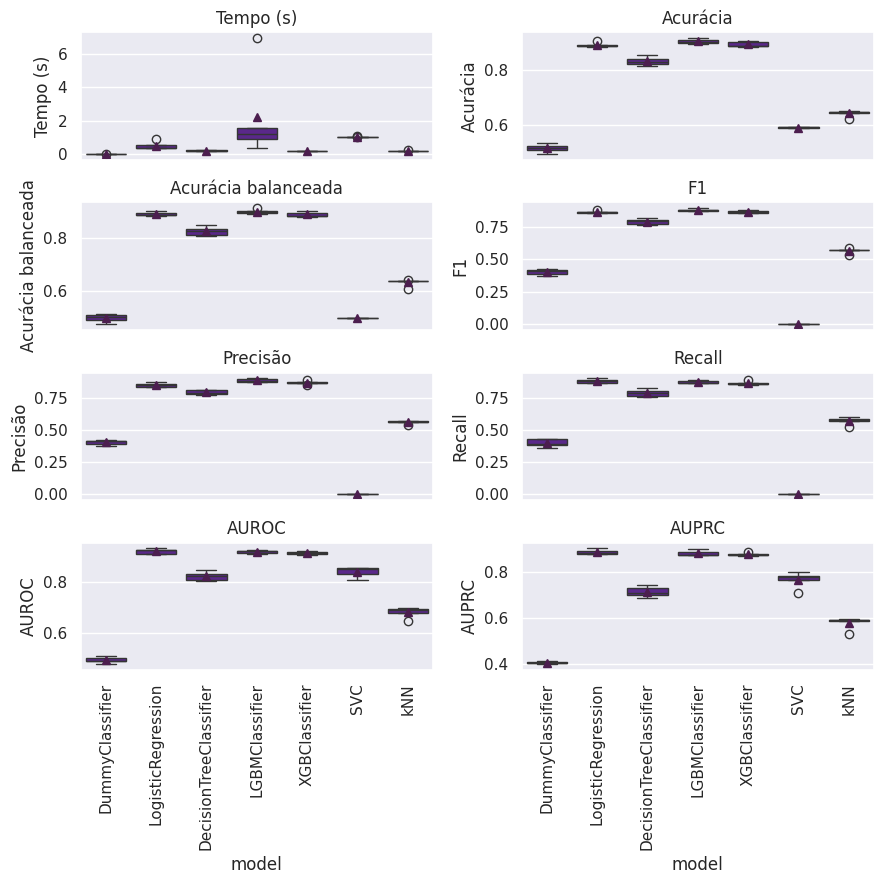

In [15]:
plot_compare_models_metrics(df_results)

A partir desses resultados percebe-se que SVM, kNN e DecisionTree não são bons modelos para os dados em questão, pois possuem as menores métricas, além do SVC ser o mais demorado.

Dentre as opções de LogisticRegression, LGBM e XGB, que possuem métricas parecidas, os modelos LGBM e LogisticRegression levaram mais tempo e se mostraram menos estáveis em relação ao tempo de execução.

Portanto, para otimizações posteriores neste estudo será escolhido o modelo XGBoost, mas dependendo da situação poderia-se escolher o LGBM ou LogisticRegression.

#### Otimização de hiperparâmetros

A partir do modelo escolhido, nesta seção serão realizadas comparações para avaliar quais são os melhores hiperparâmetros para deixar o modelo com as melhores métricas possíveis, porém evitando overfitting. Como o modelo escolhido foi de árvore, não será necessário testar o preprocessamento completo, será aplicado apenas o preprocessamento das categóricas, pois modelos de árvore não são sensíveis à escala dos dados.

In [16]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

param_grid = {
    "clf__max_depth": [6, 8, 10],
    "clf__subsample": [0.4, 0.6, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__learning_rate": [0.1, 0.3],
    "clf__n_estimators": [5, 10, 30],
    "clf__reg_lambda": [0, 1, 2],
    "clf__reg_alpha": [0, 0.5, 1],
    "clf__scale_pos_weight": [1, scale_pos_weight]
}

clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [17]:
grid_search = grid_search_cv_classifier(
    clf, param_grid, kf, preprocessing_category, refit_metric="recall"
)

grid_search.fit(X, y)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'smoking',
                                                                          'finger_discoloration',
                                                                          'mental_stress',
                                                                          'exposure_to_pollution',
                                                                          'long_term_illness',
                                                                          'immune_weakness',
                                                                          'breathing_issue',
                                                                          'alco...
                         'clf__learning_rate': [0.1, 0.3],
                         'clf__max_depth': [6, 8, 10],
                         'clf__n_estimators': [5, 10, 30],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [0, 1, 2],
                         'clf__scale_pos_weight': [1,
                                                   np.float64(1.4545900834560628)],
                         'clf__subsample': [0.4, 0.6, 1.0]},
             refit='recall',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.best_params_

{'clf__colsample_bytree': 1.0,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 6,
 'clf__n_estimators': 10,
 'clf__reg_alpha': 0.5,
 'clf__reg_lambda': 1,
 'clf__scale_pos_weight': np.float64(1.4545900834560628),
 'clf__subsample': 0.6}

In [19]:
grid_search.best_score_

np.float64(0.8954340704340705)

Após definição dos melhores hiperparâmetros para o XGBoost, ele será comparado novamente com o classificador dummy e com os modelos que performaram de maneira similar a ele inicialmente.

In [20]:
clfs_gs = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_category,
        "classifier": LogisticRegression()
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_category,
        "classifier": LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBClassifier": {
        "preprocessor": preprocessing_category,
        "classifier": grid_search.best_estimator_["clf"]
    },
}

In [21]:
results_gs = {
    model_name: train_validate_classif_model(X, y, kf, **classifier)
    for model_name, classifier in clfs_gs.items()
}

df_results_gs = organize_results(results_gs)

In [22]:
df_results_gs.groupby("model").mean().sort_values("test_recall")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.00,0.01,0.51,0.49,0.40,0.40,0.40,0.51,0.41,0.01
LGBMClassifier,0.13,0.05,0.90,0.90,0.88,0.89,0.87,0.92,0.88,0.18
LogisticRegression,0.10,0.05,0.89,0.89,0.87,0.86,0.88,0.92,0.89,0.15
XGBClassifier,0.05,0.04,0.89,0.89,0.87,0.84,0.90,0.92,0.89,0.09


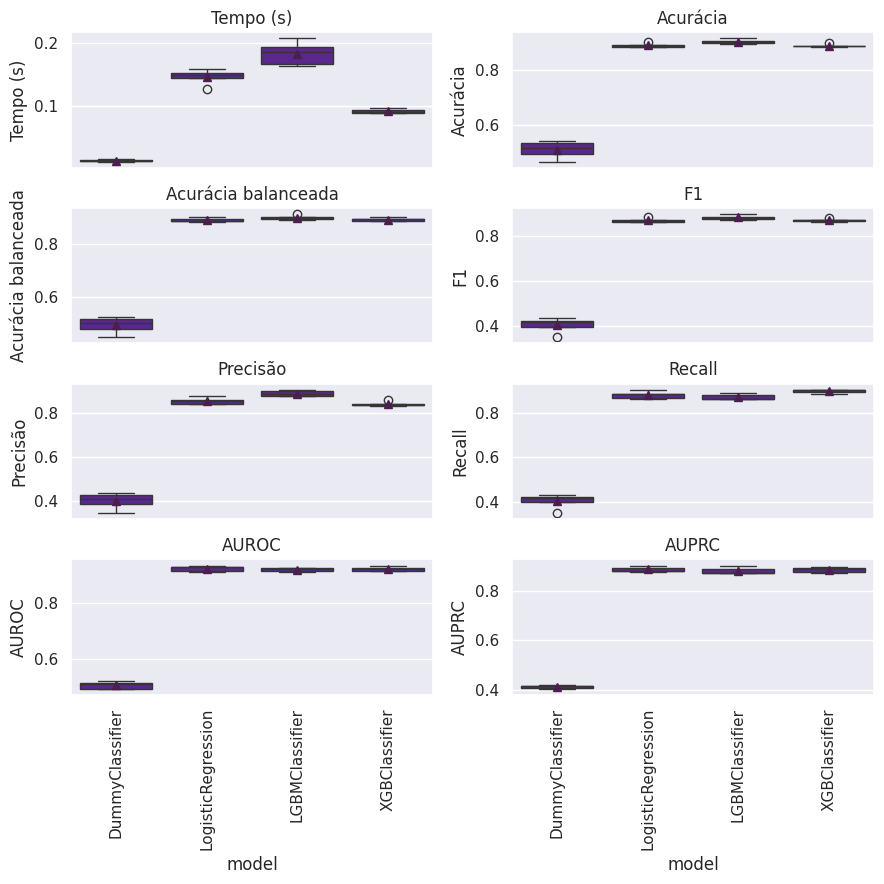

In [23]:
plot_compare_models_metrics(df_results_gs)

De acordo com estes resultados, o XGBoost otimizado se mostrou bom o suficiente para ser levado a diante como modelo para classificação de dados desta base de câncer de pulmão.

Também é possível avaliar mais detalhes do modelo escolhido. Isto será realizado a seguir.

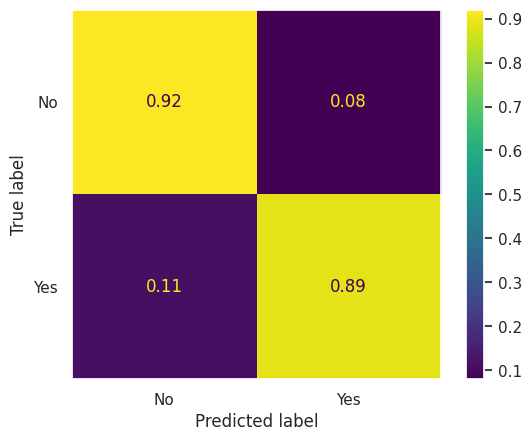

In [24]:
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X, y, display_labels=le.classes_, normalize="true")

plt.grid(False)
plt.show()

A partir da matriz de confusão é possível verificar que a maior parte das previsões estão corretas, com poucos casos classificados de modo errôneo.

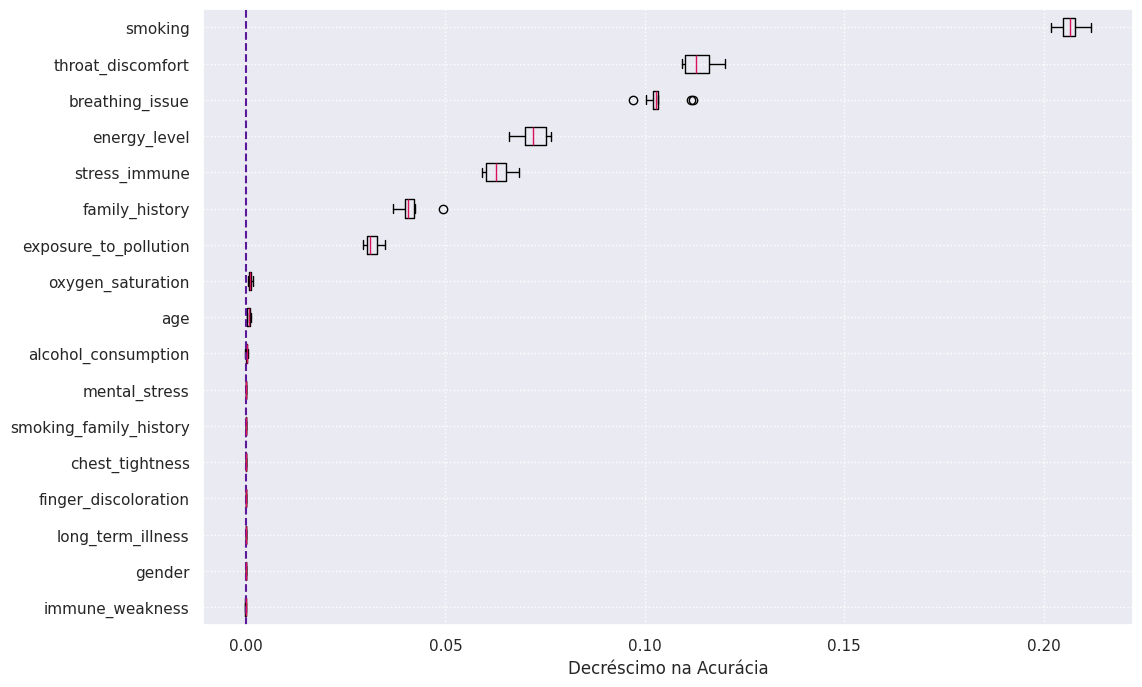

In [25]:
perm_imp = permutation_importance(
    grid_search.best_estimator_,
    X,
    y,
    n_repeats=10,
    random_state=RANDOM_STATE
)

fig, ax = plt.subplots(figsize=(12, 8))

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo na Acurácia")
ax.grid(True, linestyle=":")

plt.show()

Pelo gráfico é possível perceber que as features mais importantes para o modelo são fumo, desconforto na garganta e problemas respiratórios. Essas foram as mesmas features consideradas importantes ao longo da análise exploratória, mostrando que o modelo é condizente com os dados analisados.

Várias features parecem ter pouca importância para o modelo. Desse modo, é possível considerar uma redução na quantidade de features para avaliar a melhora na performance e diminuição tempo gasto para treinar o modelo, além de simplificar os dados necessários a serem imputados na avaliação da classificação.

#### Conclusão

Foi definido o melhor modelo para realizar as predições e os melhores parâmetros que ele pode ter para melhorar o acerto do modelo. Desse modo, é possível usar o modelo obtido para prever novos dados.

Além disso, o modelo também será salvo, podendo ser implementado em outras aplicações para além deste notebook.

In [ ]:
dump(grid_search.best_estimator_, MODELO_FINAL)